In [23]:
import torch
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Dense层的设置

In [24]:
class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate,drop_rate=0.3):
        super(DenseLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(growth_rate)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(drop_rate)
        self.residual = nn.Conv2d(growth_rate, growth_rate, kernel_size=5, padding=2)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = x+ self.residual(x)

        return x

class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers ):
        super(DenseBlock, self).__init__()
        layers = []
        for i in range(num_layers):
            layers.append(DenseLayer(in_channels + i * growth_rate, growth_rate))

        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        features = [x]
        for layer in self.layers:
            new_features = layer(torch.cat(features, dim=1))
            features.append(new_features)

        return torch.cat(features, dim=1)

Transition层加了一点残差链接和dp

In [25]:
class Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Transition, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.residual = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout2d(0.3)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x= self.relu(x)
        x = self.residual(x)
        x= self.relu(x)
        x = self.dropout(x)
        x = self.pool(x)
        return x



最终的模型

In [26]:


class DenseNet(nn.Module):
    def __init__(self, in_channels=4, growth_rate=32,  drop_rate=0.1):
        super(DenseNet, self).__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, padding=3,stride=2,bias=False),  #16*4*128*128
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2,padding=1),  #16*64*64*64
        )
        self.dense1 = DenseBlock(64, growth_rate, 6)  #16*256*64*64
        self.transition1 = Transition(256, 128)   #16*128*32*32
        self.dense2 = DenseBlock(128, growth_rate, 12) #16*512*32*32
        self.transition2 = Transition(512,256)  #16*256*16*16
        self.dense3 = DenseBlock(256, growth_rate, 12) #16*640*32*32
        self.adaptivate = nn.AdaptiveAvgPool2d((1,1))
        self.linear =nn.Sequential( nn.Linear(640, 20) )

    def forward(self, x):
        x = self.initial(x)
        x = self.dense1(x)
        x = self.transition1(x)
        x = self.dense2(x)
        x = self.transition2(x)
        x = self.dense3(x)
        x = self.adaptivate(x)
        x = x.view(x.size(0), -1).contiguous()

        x = self.linear(x)
        return x

def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.zero_()
model = DenseNet()
model.to(device)

state_dict = torch.load('model_params.pth')

model.load_state_dict(state_dict,strict=False)

C:\Users\LiuJiTing\AppData\Local\Temp\ipykernel_17020\3504306550.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('model_params.pth')


<All keys matched successfully>

数据处理，这里要更改逻辑

In [27]:
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import os
from torchvision import transforms

# 定义训练集和验证集的变换
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4,hue=0.2),
    transforms.RandomHorizontalFlip(),  # 随机水平翻转，作为数据增强的一种方式
    transforms.RandomRotation(10),  # 随机旋转10度
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# 自定义 Dataset 类，不包含 transform 逻辑
class CustomDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.labels = os.listdir(root_dir)
        self.img_paths = []

        # 遍历每个类别目录并收集样本
        for label_idx, label_name in enumerate(self.labels):
            class_dir = os.path.join(root_dir, label_name)
            for img_name in os.listdir(class_dir):
                self.img_paths.append((
                    os.path.join(class_dir, img_name),
                    label_idx
                ))

    def __getitem__(self, index):
        img_path, label = self.img_paths[index]
        img = Image.open(img_path).convert('RGBA')
        return img, label  # 不在此处应用 transform

    def __len__(self):
        return len(self.img_paths)

# Transform 包装类，动态应用不同的预处理
class TransformDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        img, label = self.dataset[index]
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.dataset)

# 创建原始数据集（无Transform）
full_dataset = CustomDataset(root_dir='../../acu_dataset')

# 划分数据集
train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_sub, val_sub, test_sub = random_split(
    full_dataset, [train_size, val_size, test_size]
)

# 为各子集应用对应的Transform
train_dataset = TransformDataset(train_sub, transform=train_transform)
val_dataset = TransformDataset(val_sub, transform=val_transform)
test_dataset = TransformDataset(test_sub, transform=val_transform)

# 创建 DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [28]:
a = iter(train_dataloader)

损失函数和优化器

In [35]:
optimizer = Adam(model.parameters(),lr = 0.001,weight_decay=0)
criterion = nn.CrossEntropyLoss()

训练函数

In [30]:
from torch.amp import autocast, GradScaler

scaler = GradScaler()

def train(num_epochs):
    model.train()

    losses = []
    epoches = torch.arange(1, num_epochs + 1)

    for epoch in range(num_epochs):
        running_loss = 0.0
        total = 0
        correct = 0
        for idx, (x, y) in enumerate(train_dataloader):
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)

            with autocast('cuda'):  # 混合精度
                y_pred = model(x)
                loss = criterion(y_pred, y)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item() * x.size(0)
            total += y.size(0)
            correct += (y_pred.argmax(dim=1) == y).sum().item()
            if (idx + 1) % 10 == 0:
                print(
                    f"Epoch [{epoch + 1}/{num_epochs}],Batches[{idx + 1}/{len(train_dataloader)}], Loss: {running_loss / ((idx + 1) * (x.size(0))):.3f} , Accuracy: {(100 * correct / total):.2f}%")
        losses.append(running_loss / len(train_dataloader.dataset))
        print(f"第{epoch + 1}轮的训练精度为：{(100 * correct / total):.2f}%\n")
    plt.plot(epoches, losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()


def val():
    model.eval()  # 设置模型为评估模式
    correct = 0
    total = 0

    with torch.no_grad():  # 不计算梯度
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  # 获取预测结果
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Validation Accuracy: {100 * correct / total:.2f}%')

def test():
    model.eval()  # 设置模型为评估模式
    correct = 0
    total = 0

    with torch.no_grad():  # 不计算梯度
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  # 获取预测结果
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')

调用函数开始训练

Epoch [1/10],Batches[10/55], Loss: 1.095 , Accuracy: 65.31%
Epoch [1/10],Batches[20/55], Loss: 1.118 , Accuracy: 66.72%
Epoch [1/10],Batches[30/55], Loss: 1.149 , Accuracy: 66.56%
Epoch [1/10],Batches[40/55], Loss: 1.126 , Accuracy: 66.88%
Epoch [1/10],Batches[50/55], Loss: 1.106 , Accuracy: 67.75%
第1轮的训练精度为：67.94%

Epoch [2/10],Batches[10/55], Loss: 0.948 , Accuracy: 70.31%
Epoch [2/10],Batches[20/55], Loss: 0.930 , Accuracy: 72.66%
Epoch [2/10],Batches[30/55], Loss: 0.954 , Accuracy: 72.08%
Epoch [2/10],Batches[40/55], Loss: 0.941 , Accuracy: 72.34%
Epoch [2/10],Batches[50/55], Loss: 0.943 , Accuracy: 72.06%
第2轮的训练精度为：71.53%

Epoch [3/10],Batches[10/55], Loss: 1.039 , Accuracy: 68.44%
Epoch [3/10],Batches[20/55], Loss: 1.019 , Accuracy: 69.06%
Epoch [3/10],Batches[30/55], Loss: 1.037 , Accuracy: 69.17%
Epoch [3/10],Batches[40/55], Loss: 1.061 , Accuracy: 68.59%
Epoch [3/10],Batches[50/55], Loss: 1.035 , Accuracy: 69.38%
第3轮的训练精度为：69.82%

Epoch [4/10],Batches[10/55], Loss: 0.932 , Acc

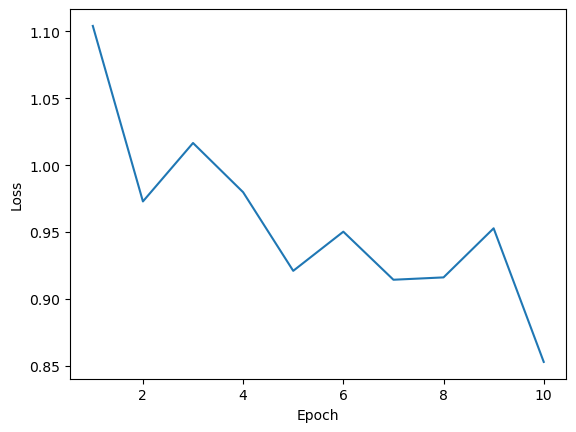

In [36]:
train(10)

In [37]:
val()
test()

Validation Accuracy: 74.05%
Test Accuracy: 69.44%


In [38]:
torch.save(model.state_dict(), 'model_params.pth')